# 🌼 Flower Classification using CNN
This project uses Convolutional Neural Networks (CNNs) to classify flower images into five categories: roses, tulips, sunflowers, daisy, and dandelions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


## 📥 Downloading Dataset
We use TensorFlow’s utility to download and extract the `flower_photos` dataset.

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).parent / "flower_photos" / "flower_photos"  # Fixing the path
# data_dir = pathlib.Path(data_dir).with_suffix('')  # Removing the .tgz suffix

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
print(data_dir)

/root/.keras/datasets/flower_photos/flower_photos


## 📊 Dataset Summary
Count the total number of images in the dataset.

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


## 🖼️ Preview Images
Let's visually inspect some sample images from the dataset.

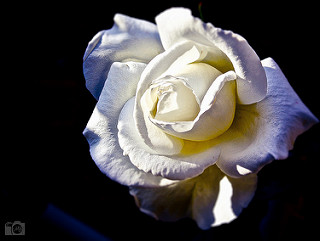

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

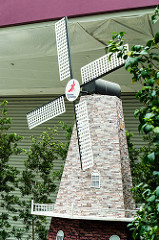

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))


## 🧹 Dataset Preparation
Use `image_dataset_from_directory` to load images for training and validation with proper labels.

In [7]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 🔍 Visualize Batches
Display a few images from the training dataset along with their class labels.

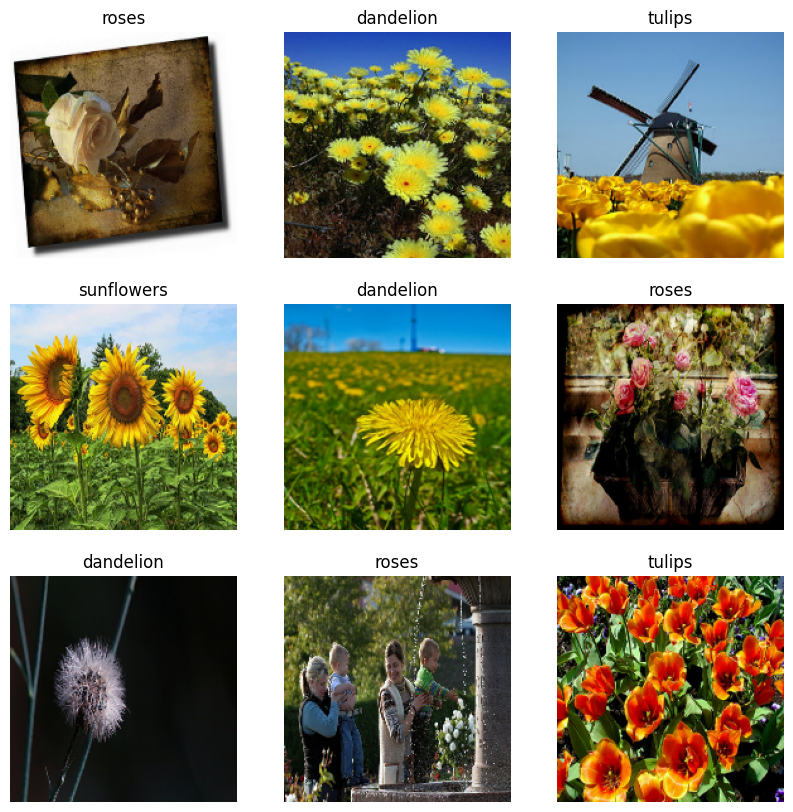

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## ⚡ Performance Optimization
Enable caching and prefetching for faster training.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

## 📏 Normalize Image Data
Scale pixel values to the [0, 1] range for consistency with model training.

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## 🧠 CNN Model Architecture
Define the model structure using Keras Sequential API.

In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## ⚙️ Compile the Model
Specify loss function, optimizer, and accuracy metric.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 🚀 Train the Model
Train the model using training and validation datasets.

In [15]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3342 - loss: 1.6634 - val_accuracy: 0.5913 - val_loss: 1.0457
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6327 - loss: 0.9601 - val_accuracy: 0.6294 - val_loss: 0.9297
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6973 - loss: 0.7853 - val_accuracy: 0.6403 - val_loss: 0.9168
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7893 - loss: 0.5838 - val_accuracy: 0.6390 - val_loss: 1.0074
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8959 - loss: 0.3110 - val_accuracy: 0.6035 - val_loss: 1.1744
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9440 - loss: 0.1896 - val_accuracy: 0.6063 - val_loss: 1.4594
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9608 - loss: 0.1414 - val_accuracy: 0.6199 - val_loss: 1.5150
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9883 - loss: 0.0597 - val_accuracy: 0.6172 - 

## 📈 Evaluate Model Performance
Visualize training and validation accuracy/loss over epochs.

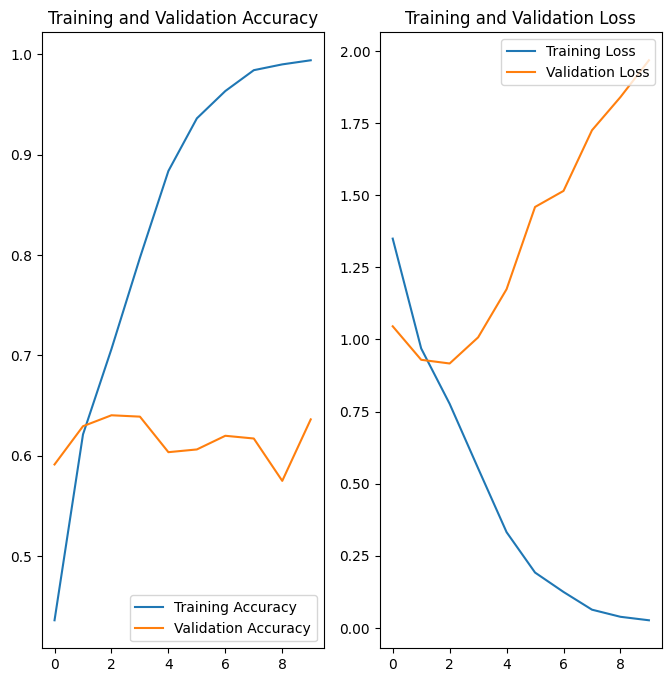

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Analysis of Plots
In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy is around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting.

## 🔄 Data Augmentation

**Data augmentation** is a technique used to artificially increase the size and diversity of a training dataset by applying random transformations to the input images. These transformations simulate real-world variations, helping the model generalize better and avoid overfitting.

In this project, the following augmentations were applied:
- **Random Flip:** Horizontally flips the image.
- **Random Rotation:** Rotates the image by a small random degree.
- **Random Zoom:** Zooms into a random area of the image.

By introducing variations in the training data, data augmentation allows the model to learn more robust and invariant features, improving performance on unseen data.


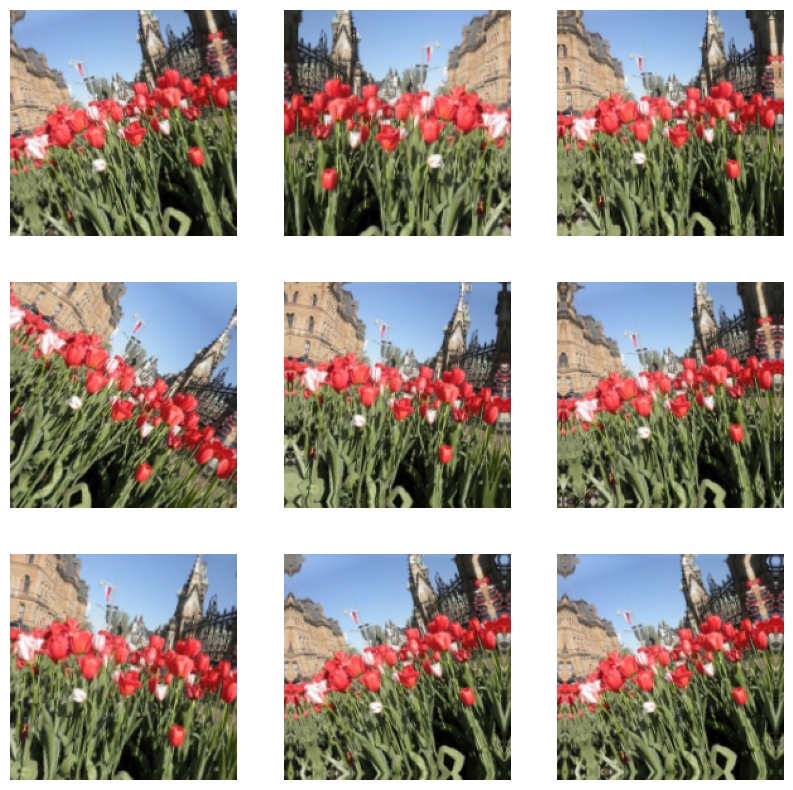

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 🧠 Retrain with Augmentation
Use the augmented data for improved generalization.

In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 📈 Retrain Model Evaluation

In [20]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3094 - loss: 1.6355 - val_accuracy: 0.5708 - val_loss: 1.0637
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5682 - loss: 1.0629 - val_accuracy: 0.5736 - val_loss: 1.0456
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6180 - loss: 0.9607 - val_accuracy: 0.6172 - val_loss: 0.9645
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6491 - loss: 0.8980 - val_accuracy: 0.6431 - val_loss: 0.8671
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6691 - loss: 0.8393 - val_accuracy: 0.6689 - val_loss: 0.8596
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6979 - loss: 0.7838 - val_accuracy: 0.6962 - val_loss: 0.7699
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7120 - loss: 0.7600 - val_accuracy: 0.7084 - val_loss: 0.7298
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7295 - loss: 0.6916 - val_accuracy: 0.7153 - v

## Visualize Training Results
Plot updated training curves.

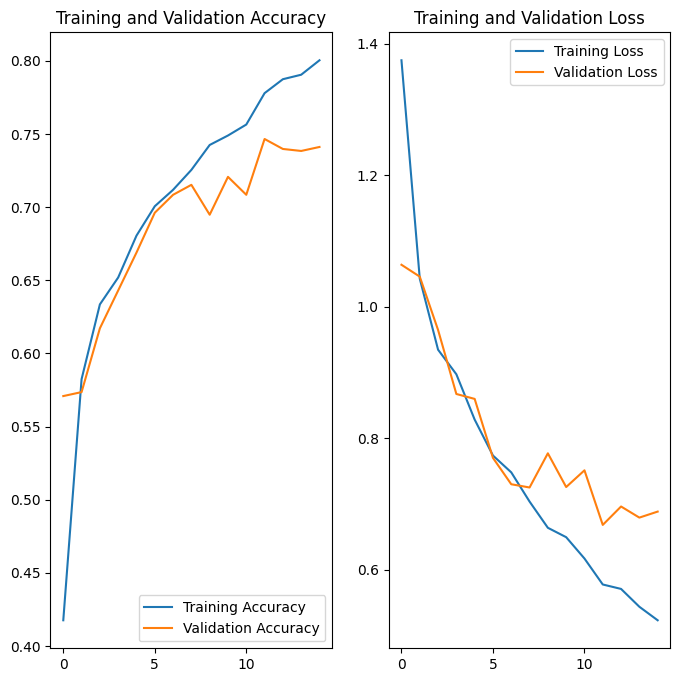

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 🌻 Predicting on New Image
Download and classify a new flower image using the trained model.

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
This image most likely belongs to sunflowers with a 99.45 percent confidence.


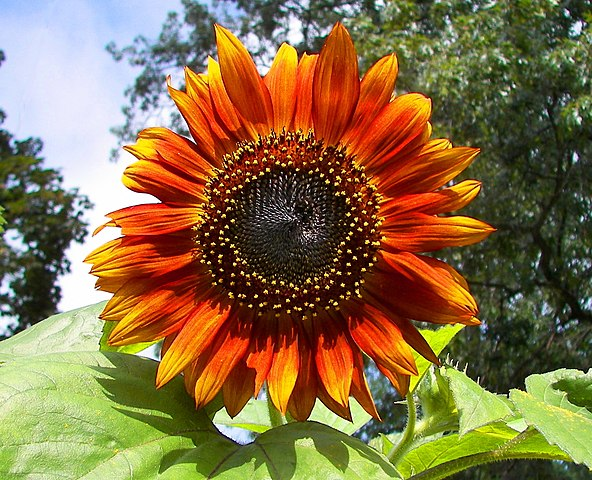

In [22]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(sunflower_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
tf.Tensor([3.8017160e-06 3.6638651e-06 8.6387819e-01 1.9214398e-04 1.3592221e-01], shape=(5,), dtype=float32)
This image most likely belongs to roses with a 86.39 percent confidence.


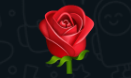

In [23]:
image_path = 'rose.png'
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(image_path)


## 🚫 Dropout

**Dropout** is a regularization technique that helps prevent overfitting in neural networks. During training, dropout randomly "drops out" (sets to zero) a fraction of the neurons in a layer. This prevents the model from relying too heavily on specific neurons and encourages it to learn more general features.

In this project, a `Dropout` layer was added after the convolutional layers to reduce overfitting and decrease computation.

- **Effect:** The training was faster and required fewer resources.
- **Trade-off:** The accuracy slightly decreased, showing that while dropout improves generalization in many cases, it may not always outperform data augmentation alone, especially with a relatively small dataset.

### 🧠 Add Dropout Regularization
Combine data augmentation with dropout to improve robustness.

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## 📈 Final Model Evaluation
Visualize accuracy and loss for the final model.

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3712 - loss: 1.4312 - val_accuracy: 0.5504 - val_loss: 1.1182
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5699 - loss: 1.0913 - val_accuracy: 0.5749 - val_loss: 1.1036
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6340 - loss: 0.9669 - val_accuracy: 0.5749 - val_loss: 1.0422
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6440 - loss: 0.9081 - val_accuracy: 0.6362 - val_loss: 0.9093
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6989 - loss: 0.7992 - val_accuracy: 0.6621 - val_loss: 0.8507
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6878 - loss: 0.7958 - val_accuracy: 0.6962 - val_loss: 0.7639
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7290 - loss: 0.7164 - val_accuracy: 0.6826 - val_loss: 0.8590
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7183 - loss: 0.7318 - val_accuracy: 0.7057 - v

## Visualize Training Results

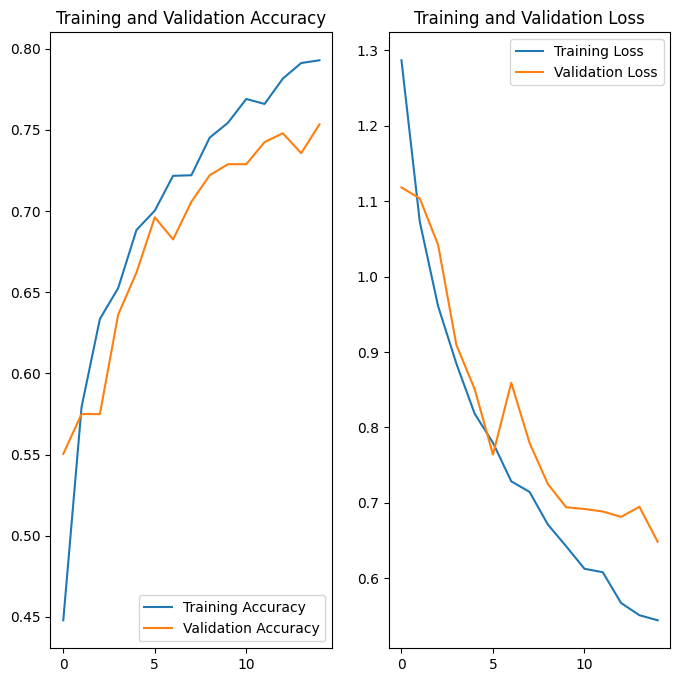

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 🌼 Final Prediction
Predict the class of a completely new flower image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
This image most likely belongs to sunflowers with a 96.31 percent confidence.


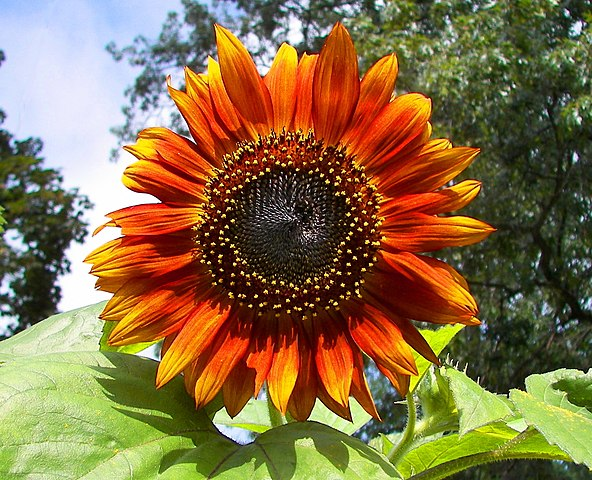

In [28]:
# @title Prediction
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(sunflower_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
tf.Tensor([9.2049944e-01 2.0131857e-04 7.2344214e-02 1.6290160e-03 5.3259553e-03], shape=(5,), dtype=float32)
This image most likely belongs to daisy with a 92.05 percent confidence.


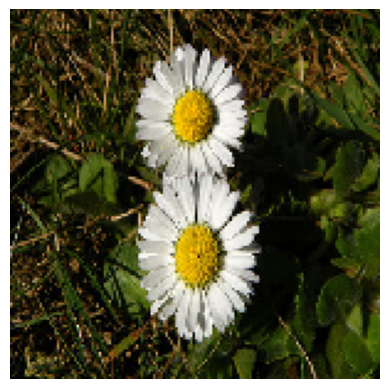

In [30]:
image_path = 'daisy.png'
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(image_path)

## ✅ Conclusion

In this project, we explored different techniques to improve the performance of a Convolutional Neural Network (CNN) for flower classification using the `flower_photos` dataset.

Two strategies were implemented:

- **Data Augmentation**, to increase dataset diversity and improve generalization.
- **Dropout (along with Data Augmentation)**, to reduce overfitting by randomly deactivating neurons during training.

### 🔍 Key Observations:

- Both models — one using only data augmentation and the other using dropout along with data augmentation — achieved **similar training times and accuracy levels**.
- This suggests that **data augmentation alone was sufficient** to regularize the model effectively for this dataset.
- **Dropout did not offer significant additional benefit** in terms of accuracy or training efficiency in this case, likely due to the already generalized nature of the augmented data.

### 📌 Final Insight:
> For this dataset and CNN architecture, **data augmentation** alone is a robust and effective approach to enhance performance. Dropout can still be a valuable regularization tool, but its impact may vary depending on model complexity and dataset size.